In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [2]:
df = pd.read_csv(r'C:\Users\shivt\OneDrive\Desktop\SELF\GaTech\Courses\Warehousing\Data\Demand_WB1_210918.csv')
df.head()

,Year,Month,Day,FC,Market Category,Product,Region,Units
0,1,1,1,1,1,1,0,0.0900
1,1,1,1,1,1,2,0,0.0900
2,1,1,1,1,1,3,0,0.0225
3,1,1,1,1,1,4,0,0.0225
4,1,1,2,1,1,1,0,0.1350


In [3]:
df.count()

Year               604800
Month              604800
Day                604800
FC                 604800
Market Category    604800
Product            604800
Region             604800
Units              604800
dtype: int64

In [4]:
for i in range(len(list(df))):
    print(df.columns[i] ,df.iloc[:,i].unique())

Year [ 1  2  3  4  5  6  7  8  9 10]
Month [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
FC [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Market Category [1 2 3]
Product [1 2 3 4]
Region [0]
Units [9.00000000e-02 2.25000000e-02 1.35000000e-01 ... 2.70349004e+01
 2.16279203e+01 4.32558406e+01]


In [5]:
df_aggregated = df.groupby(by=['Year', 'Month', 'Day', 'FC', 'Market Category', 'Region'])['Units'].sum()

In [6]:
#df_aggregated.groupby(by=['Year']).sum()   
#matches df.groupby(by='Year')['Units'].sum()

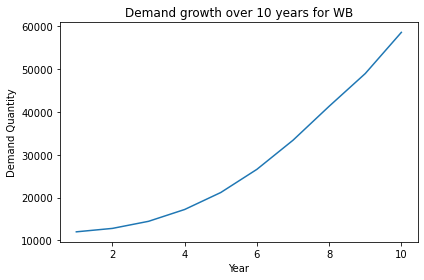

In [7]:
plt.plot(df_aggregated.groupby(by=['Year']).sum())
plt.title('Demand growth over 10 years for WB')
plt.xlabel('Year')
plt.ylabel('Demand Quantity')
plt.tight_layout()

### Finding FC level demand for each market and deriving customer visits 

In [8]:
df_aggregated= df_aggregated.reset_index()

In [9]:
df_1_2 = df_aggregated[(df_aggregated['Market Category']==1) | (df_aggregated['Market Category']==2)].reset_index(drop=True)

In [10]:
df_1_2.groupby('Year').sum()

,Month,Day,FC,Market Category,Region,Units
Year,,,,,,
1,65520,146160,80640,15120,0,360.000000
2,65520,146160,80640,15120,0,991.597531
3,65520,146160,80640,15120,0,2712.498642
4,65520,146160,80640,15120,0,4620.049756
5,65520,146160,80640,15120,0,7962.099435
6,65520,146160,80640,15120,0,12687.896942
7,65520,146160,80640,15120,0,18699.271723
8,65520,146160,80640,15120,0,26421.942044
9,65520,146160,80640,15120,0,35999.416234


In [10]:
df[(df['Market Category']==1) | (df['Market Category']==2)].groupby(by='Year')['Units'].sum()

Year
1       360.000000
2       991.597531
3      2712.498642
4      4620.049756
5      7962.099435
6     12687.896942
7     18699.271723
8     26421.942044
9     35999.416234
10    45039.352774
Name: Units, dtype: float64

In [11]:
df[(df['Market Category']==3)].groupby(by='Year')['Units'].sum()

Year
1     11640.000000
2     11809.395061
3     11741.936420
4     12595.499887
5     13217.697562
6     13897.950083
7     14681.536349
8     14881.777444
9     12938.570664
10    13517.450185
Name: Units, dtype: float64

In [12]:
print(df.groupby(by='FC')['Units'].sum()[:-1].sum())
print(df.groupby(by='Year')['Units'].sum().sum())

159195.41456199065
286415.938737442


In [15]:
%%time
# df_1_2.apply(lambda x : get_cust_visit(x['Market Category'],x['Units'] ), axis=1)

#Customer interaction characterization
#simulation sample size for estimated customer interaction %
max_sim_customer_sample = 50
sim_upper_bound_percentile = 97.5
sim_lower_bound_percentile = 2.5

#primary market
prim_mean_visit = 0.75
prim_min_visit = 0.5
prim_max_visit = 0.9




#secondary market
sec_mean_visit = 0.2
sec_min_visit = 0.1
sec_max_visit = 0.35

#calculate estimations of customer visits based on demand expected
np.random.seed=1 
visits_count=list(df_1_2.apply(lambda x : get_cust_visit(x['Market Category'], x['Units']), axis=1))

#attach results together and rename
df_customer_visit_final = pd.concat([df_1_2, pd.DataFrame(visits_count)], axis =1)
df_customer_visit_final=df_customer_visit_final.rename(columns= {0:'Min visits',1:'Mean visits', 2:'Max visits'})

Wall time: 41.2 s


In [14]:
def get_cust_visit(market, units_demand):
    """
    Function to find out mean, max and min customer visit for each FC primary and secondary transaction. 
    Assumptions : 
        1. The value of visits post multiplied by customer interaction factor should always >0 otherwise it 
    will be taken out of distribution and remaining values will get calculated to find mean, max and min 
        2. Upper limit of customer interaction is capped by transactions that have happened
        3. If unit is zero - customer interaction for that line is zero
    Argument :
        market (int)  : primary or secondary market variable (1 or 2)
        units_demand (float) : each unit demand for that combination
    
    """
    if units_demand>0:
        if market==1:
            visits_p = []
            for j in range(max_sim_customer_sample):
                ####generating estimated number 
                visits_p.append( units_demand*(prim_mean_visit+(prim_max_visit-prim_min_visit)*(1/6)*np.random.normal(0,1)))
                item_instore_conclusion = units_demand*(prim_mean_visit+(prim_max_visit-prim_min_visit)*(1/6)*np.random.normal(0,1))
                

            visits_p=np.asarray(visits_p)
#             print(visits_p)
#             print(visits_p[visits_p>0])
            visits_p=visits_p[(visits_p>0) & ((visits_p)<=units_demand)]
            expected_visit_mean = np.percentile(visits_p,50)
            expected_visit_high = np.percentile(visits_p,sim_upper_bound_percentile)
            expected_visit_low = np.percentile(visits_p,sim_lower_bound_percentile)

        if market==2:
            visits_p = []
            for j in range(max_sim_customer_sample):
                ####generating estimated number 
                ## assumed that lower would be 10% and upper would be 35 percent same delta for given in case document 
                visits_p.append(units_demand*(sec_mean_visit+(sec_max_visit-sec_min_visit )*(1/6)*np.random.normal(0,1)))  
            visits_p=np.asarray(visits_p, dtype=float)
            visits_p=visits_p[visits_p>0 & ((visits_p)<=units_demand)]
            expected_visit_mean = np.percentile(visits_p,50)
            expected_visit_high = np.percentile(visits_p,sim_upper_bound_percentile)
            expected_visit_low = np.percentile(visits_p,sim_lower_bound_percentile)
#         print(expected_visit_low, expected_visit_mean,expected_visit_high)
        return expected_visit_low, expected_visit_mean,expected_visit_high
    else :
#         print(0,0,0)
        return 0,0,0

In [16]:
df_customer_visit_final.groupby(by='Year').sum()

,Month,Day,FC,Market Category,Region,Units,Min visits,Mean visits,Max visits
Year,,,,,,,,,
1,65520,146160,80640,15120,0,360.000000,196.891535,237.281089,278.190706
2,65520,146160,80640,15120,0,991.597531,496.215957,604.324501,711.159874
3,65520,146160,80640,15120,0,2712.498642,1331.327317,1624.262479,1917.236037
4,65520,146160,80640,15120,0,4620.049756,2296.653750,2797.259545,3295.720779
5,65520,146160,80640,15120,0,7962.099435,4011.389484,4879.479936,5747.017178
6,65520,146160,80640,15120,0,12687.896942,6476.724051,7861.376840,9244.094558
7,65520,146160,80640,15120,0,18699.271723,9610.795218,11665.948273,13718.078363
8,65520,146160,80640,15120,0,26421.942044,13653.012600,16579.006858,19478.511264
9,65520,146160,80640,15120,0,35999.416234,18655.578780,22620.546365,26589.733203


Text(0, 0.5, 'Number of customer visits')

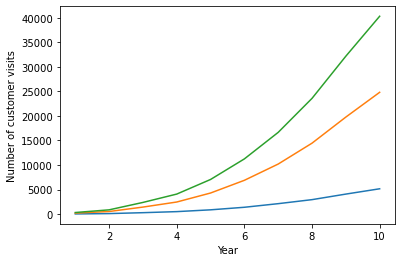

In [219]:
plt.plot(df_customer_visit_final.groupby(by='Year').sum()[['Min visits','Mean visits','Max visits']])
plt.xlabel('Year')
plt.ylabel('Number of customer visits')

### Estimating customer visit initiation and conclusion counts

In [12]:
expected_visit = 1000

In [150]:
get_initi_concl_visits(100)

40.41913613842905


((33.38423338762686, 40.41913613842905, 45.60035656521431), 54.39964343478569)

In [163]:


def get_initi_concl_visits(expected_visit):
    """
    This function takes the expected customer visit number from get_cust_visit() function and breaks it down to 
    customer initiation, conclusion and delivery numbers
    
    Assumption :
    1. All distributions follow gaussian normal
    2. One customer only interacts with store only once
    3. One customer only buys one item from the store or online
    Arg:
    1. expected_visit (float) : Expected customer visit 
    """
    #defining the distribution bounds for customers who are estimated to conclude the transaction through store
    #picking up and taking home immediately on store visit is considered as two different transactions concluded in store
    Total_visits_cncld_store_mean_per = 0.4
    Total_visits_cncld_store_max_per = 0.5
    Total_visits_cncld_store_min_per = 0.3
    
    
    #defining the distribution for customers who seriously initiate the interaction in store. That means defining 
    #distribution of customers who will order online for any given day
    #certain percent of these customers will initiate in store but get it delivered home
    Total_initiation_in_Store_min_per = 0.3   #ie 70% initiated it online and they come to pick up 
    Total_initiation_in_Store_mean_per = 0.5  #ie 50% initiated it online and they come to pick up 
    Total_initiation_in_Store_max_per = 0.7   ##ie 30% initiated it online and they come to pick up
    
    
    
    #Dataframe to store breakdown of total customer interaction
    final_cust_interaction = pd.DataFrame(columns=['Total_visits_cncld_store_min', 
                                                   'Total_visits_cncld_store_mean',
                                                  'Total_visits_cncld_store_max',
                                                   'Total_visits_cncld_delivery_init_store_min',
                                                   'Total_visits_cncld_delivery_init_store_mean',
                                                   'Total_visits_cncld_delivery_init_store_max',
                                                   'Net_vists_init_store_cncld_store_min',
                                                   'Net_vists_init_store_cncld_store_mean',
                                                   'Net_vists_init_store_cncld_store_max'
                                                  ])
    
    #simulate the distribution and get min, mean and maximum numbers
    _total_store_concld_arr= simulate_rv(max_sim_customer_sample, expected_visit,Total_visits_cncld_store_min_per,
                Total_visits_cncld_store_mean_per, Total_visits_cncld_store_max_per)
    
    #calling get_mean_range to obtain mean, max and min of this sample
    Total_visits_cncld_store= get_mean_range(_total_store_concld_arr, expected_visit_mean)
    
    #adding total customer visits to final dataframe
    final_cust_interaction=final_cust_interaction.append({'Total_visits_cncld_store_min':Total_visits_cncld_store[0],
                            'Total_visits_cncld_store_mean':Total_visits_cncld_store[1],
                            'Total_visits_cncld_store_max':Total_visits_cncld_store[2]}, ignore_index=True)
    
    
    #Calculating total initiated in store strictly but delivered to home ie concluded at home delivery
    Total_visits_cncld_delivery_init_store_min = expected_visit - Total_visits_cncld_store[2] #N-max = min of delivery
    Total_visits_cncld_delivery_init_store_mean = expected_visit - Total_visits_cncld_store[1] #N-mean = mean of delivery
    Total_visits_cncld_delivery_init_store_max = expected_visit - Total_visits_cncld_store[0] #N-min = max of delivery
    
    final_cust_interaction['Total_visits_cncld_delivery_init_store_min']= Total_visits_cncld_delivery_init_store_min
    final_cust_interaction['Total_visits_cncld_delivery_init_store_mean']= Total_visits_cncld_delivery_init_store_mean
    final_cust_interaction['Total_visits_cncld_delivery_init_store_max']= Total_visits_cncld_delivery_init_store_max
    
    
    #Going one level deeper - split total people who concluded at store into two buckets
    #1. People who initiated in store and also immediately concluded in store - bought and pickedup immediately
    #2. People who initiated online and picked up from store ie concluded in store
    
    #Process --> Take total customer visit to store --> find mean of customers who might have initiated in store and immediately pickedup
    # --> customers that have initiated online and concld in store = total vists cncld in store - total initiated in store and immediately pickedup
    
    ###mean value of total people who concluded in store
    print(Total_visits_cncld_store[1], 'mean')
    _total_inti_store_cncld_store = simulate_rv(max_sim_customer_sample, Total_visits_cncld_store[1],
                                               Total_initiation_in_Store_min_per,
                                               Total_initiation_in_Store_mean_per,
                                               Total_initiation_in_Store_max_per)
    #get only mean of this population and leave max and min 
    _total_inti_store_cncld_store_mean = get_mean_range(_total_inti_store_cncld_store,Total_visits_cncld_store[1])[1] 
    
    #assigning this back to main dataframe
    final_cust_interaction['Net_vists_init_store_cncld_store_mean']= _total_inti_store_cncld_store_mean
    
    ###min value of total people who concluded in store
    print(Total_visits_cncld_store[0], 'min')
    _total_inti_store_cncld_store = simulate_rv(max_sim_customer_sample, Total_visits_cncld_store[0],
                                               Total_initiation_in_Store_min_per,
                                               Total_initiation_in_Store_mean_per,
                                               Total_initiation_in_Store_max_per)
    #get only mean of this population and leave max and min 
    _total_inti_store_cncld_store_min = get_mean_range(_total_inti_store_cncld_store,Total_visits_cncld_store[0])[1] 
    
    #assigning this back to main dataframe
    final_cust_interaction['Net_vists_init_store_cncld_store_min']= _total_inti_store_cncld_store_min
    
    ###max value of total people who concluded in store
    print(Total_visits_cncld_store[2], 'max')
    _total_inti_store_cncld_store = simulate_rv(max_sim_customer_sample, Total_visits_cncld_store[2],
                                               Total_initiation_in_Store_min_per,
                                               Total_initiation_in_Store_mean_per,
                                               Total_initiation_in_Store_max_per)
    #get only mean of this population and leave max and min 
    _total_inti_store_cncld_store_max = get_mean_range(_total_inti_store_cncld_store,Total_visits_cncld_store[2])[1] 
    
    #assigning this back to main dataframe
    final_cust_interaction['Net_vists_init_store_cncld_store_max']= _total_inti_store_cncld_store_max
    
    
    print(_total_inti_store_cncld_store_mean)
    print(_total_inti_store_cncld_store_min,'min')
    print(_total_inti_store_cncld_store_max,'max')
    print(final_cust_interaction)
    return Total_visits_cncld_store, Total_visits_cncld_delivery_init_store_min

    
    

# get_initi_concl_visits(100)

In [143]:
def get_mean_range(array, unit_multiplier):
    """
    This function to be used inside get_initi_concl_visits and calculates min, mean and max of given sample at 
    predefined percentiles 

    """
    array=array[(array>0) & (array<=unit_multiplier)]
    mean = np.percentile(array, 50)
    max = np.percentile(array, sim_upper_bound_percentile)
    min = np.percentile(array, sim_lower_bound_percentile)
    
    return min, mean, max 
    
    

In [18]:
max_sim_customer_sample = 50
sim_upper_bound_percentile = 97.5
sim_lower_bound_percentile = 2.5

In [142]:
def simulate_rv(simulation_sample_size, unit_multiplier, min_of_rv, mean_rv, max_of_rv):
    """
    This function simulates given random variables assuming it follows normal gaussian distribution for given number 
    sample size.
    
    Arg :
    1. simulation_sample_size (int) : Number of samples you want to create in at given time
    2. unit_multiplier (float) : Any unit quantity that is getting broken down by this random variable
    3. min_of_rv, mean_rv, max_of_rv (float) : min, mean and max bounds for the random variable
    
    Returns :
    1. sample (np.array) : array of simulated sample items
    """
    sample = []
    for i in range(simulation_sample_size ):
        ith_sample = unit_multiplier *(mean_rv+(max_of_rv-min_of_rv )*(1/6)*np.random.normal(0,1))
        
        sample.append(ith_sample)
    
    sample= np.asarray(sample, dtype= float)
    return sample